In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

from ModelTesters.ModelTester import ModelTester
from utils.ErrorMetrics import calculate_all_errors
from utils.DataPrepUtils import xy_backtest
from utils.progress import ProgressBar
progress = ProgressBar()

In [2]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

## ANN Model

In [112]:
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor

In [1]:
from AutoValidator.ErrorMetrics import calculate_all_errors, __error_metrics__

def speed_up_calc(tester, data, horizon, back_horizon):
    # Loading bar
    tester.progressBar.set_length(len(data.columns) * 10)

    tester.actuals = {}
    test_data = {}
    
    # walk speed up
    for i, column in enumerate(data.keys()):
        # Split into train and test data
        split = int(0.20 * len(data))
        train, test = data[column][:split].values, data[column][split:].values
        
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]
        
        # Create a mapping of the past back_horizon samples to the next horizon samples
        # eg. the past 100 points as X and the next 5 points at y
        col = data[column].values.flatten()
        indexer = np.arange(back_horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
        X = col[indexer]
    
        indexer = back_horizon + np.arange(horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
        y = col[indexer]
        
        # Scale the data to be between 0 and 1 to prevent saturating activation functions of NN
        sc = MinMaxScaler()
        X = sc.fit_transform(X)
        y = sc.fit_transform(y)
        
        set_errors = pd.DataFrame(columns=__error_metrics__)
        preds = []
        actuals = []
        train = []
        for i, (X_train, X_test, y_train, y_test) in enumerate(xy_backtest(X, y, 0.2, int(0.8 * len(X)) // 10)): 
            # Fit and save the predictions
            model.fit(X_train, y_train, epochs=30, validation_split=0.2)
            pred = sc.inverse_transform(tester.model.predict(X_test))
            actual = sc.inverse_transform(y_test)

            preds += [pred]
            actuals += [actual]

            # Calculate and save all error metrics
            errors = {}
            for key, value in calculate_all_errors(sc.inverse_transform(y_train), actual[:, 0], pred, horizon).items():
                errors[key] = [value]
    
            t = pd.DataFrame.from_dict(errors)
            t.set_index(keys=[[column]], inplace=True)
            set_errors = set_errors.append(t)
            
            # Update the progress bar
            print(y_test.shape, y_test.shape, y_train.shape)
            tester.progressBar.progress()

        # Save the predictions and actual results for the dataset
        preds, actuals = np.vstack(preds), np.vstack(actuals)
        tester.predictions[column] = preds
        tester.actuals[column] = actuals

        tester.errors = tester.errors.append(set_errors.loc[column].mean(axis=0), ignore_index=True)

## 1 minute horizon

In [204]:
horizon = 1

# create model
model = Sequential()
model.add(Dense(200, input_dim=100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

one_min_tester = ModelTester(data, model, horizon, 0.20)

In [ ]:
speed_up_calc(one_min_tester, data, horizon, 100)

In [287]:
one_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE,MASE1
name,,,,,,,,,
window_1_0,29.698869,76.647218,127.319474,27.404017,0.101334,NaN,NaN,0.164793,1406.02446
window_1_1,39.554222,49.662759,34.299205,19.788819,0.141652,NaN,NaN,0.140479,-717.95376
window_1_2,135.995985,306.572959,107.330993,35.501921,0.432584,NaN,NaN,0.328794,-138.43928
window_1_3,82.506590,199.781194,89.658643,33.162888,0.212909,NaN,NaN,0.230978,-154.53793
window_1_4,89.327802,182.336686,133.285739,56.808794,0.303763,NaN,NaN,0.361417,-225.37575


<IPython.core.display.Javascript object>


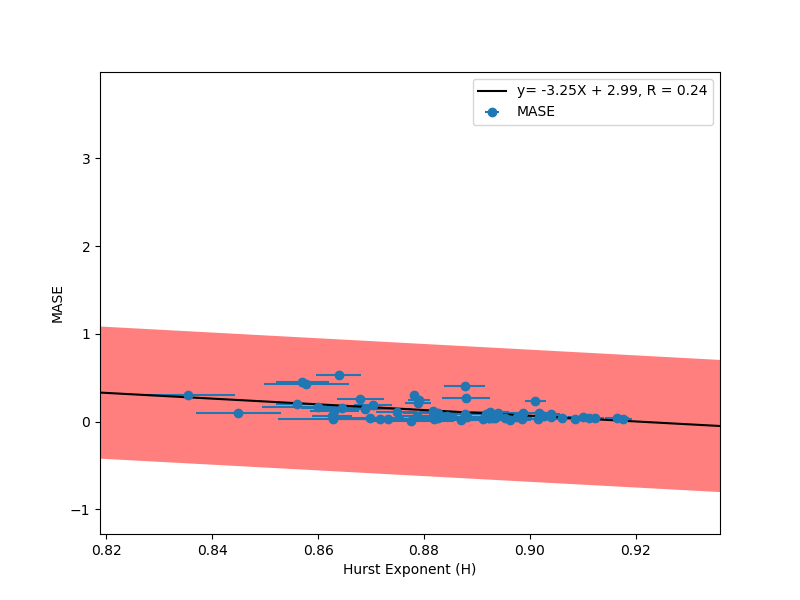

In [289]:
one_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for ANN at 1 minute horizon')
plt.ylim([-1, 2])

In [291]:
one_min_tester.errors.to_csv('results/one_minute_ann_results.csv')

<IPython.core.display.Javascript object>


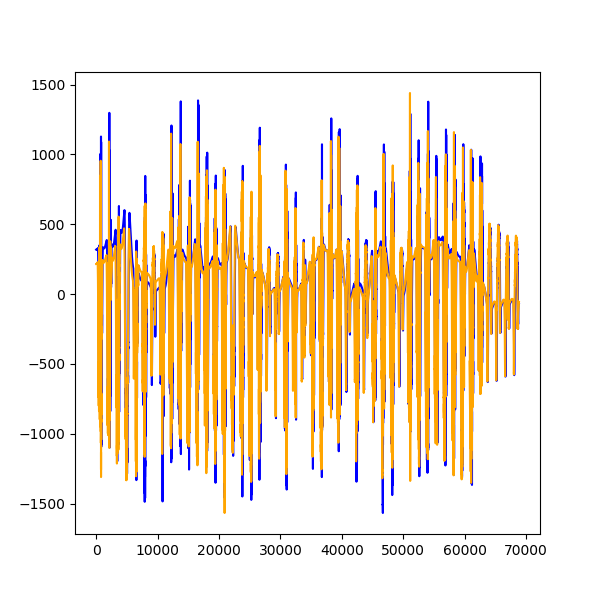

(68840,)


In [290]:
%matplotlib notebook
one_min_tester.visualise_result([0])

## 5 minute horizon

In [191]:
horizon = 5

# create model
model = Sequential()
model.add(Dense(200, input_dim=100, activation='relu'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(5, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
EarlyStopping(monitor='mae', min_delta=0, patience=1)

five_min_tester = ModelTester(data, model, horizon, 0.20)

In [193]:
speed_up_calc(five_min_tester, data, horizon, 100)

Progress: [####################] 100.0%


In [194]:
five_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE,MASE1
0,104.123139,215.984724,111.054017,44.300615,0.373119,NaN,NaN,0.359788,433.153297
1,109.039066,256.194502,130.908786,41.061239,0.422058,NaN,NaN,0.367255,-423.303886
2,149.680756,300.037757,402.564533,56.586257,0.478320,NaN,NaN,0.460968,-468.191676
3,143.818945,312.890466,107.866975,43.870231,0.368836,NaN,NaN,0.377654,-101.576920
4,162.750139,327.041396,175.045522,68.466311,0.550346,NaN,NaN,0.560956,-185.115623


<IPython.core.display.Javascript object>


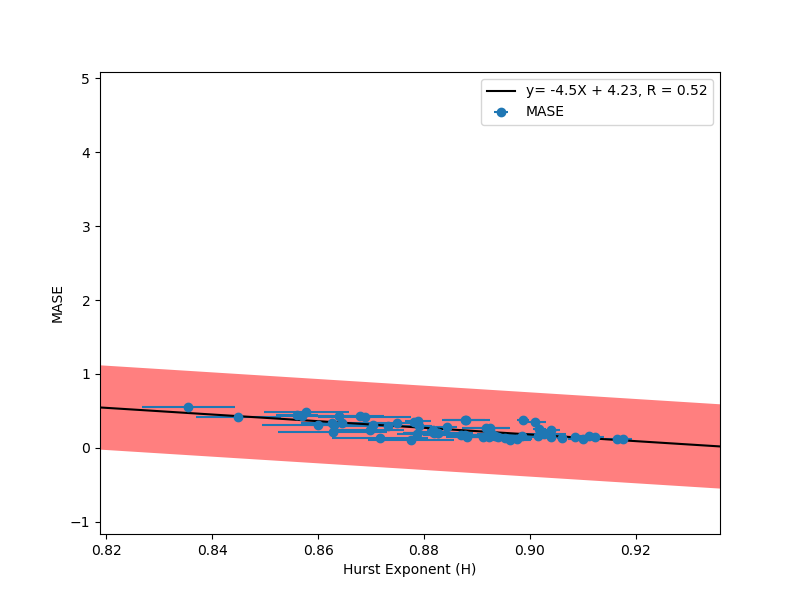

In [195]:
five_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for ANN at 5 minute horizon')
plt.ylim([-1, 2])

In [292]:
five_min_tester.errors.to_csv('results/five_minute_ann_results.csv')

<IPython.core.display.Javascript object>


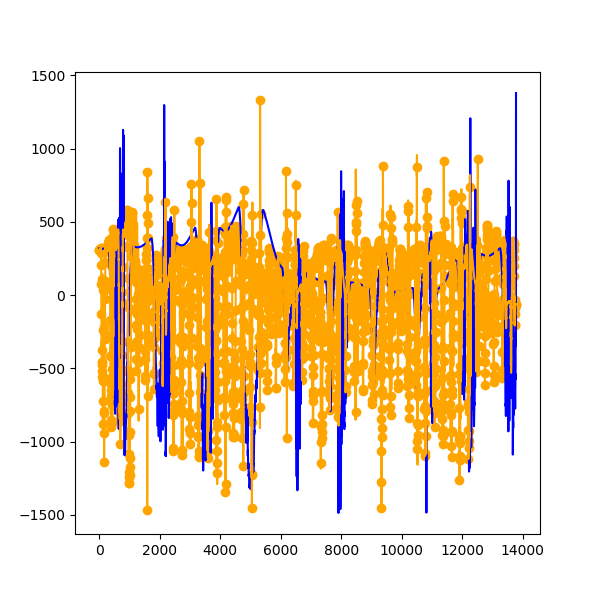

In [127]:
five_min_tester.visualise_result([0])

## 60 minute horizon

In [200]:
horizon = 60

# create model
model = Sequential()
model.add(Dense(300, input_dim=200, activation='relu'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(60, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
EarlyStopping(monitor='mae', min_delta=0, patience=1)

sixty_min_tester = ModelTester(data, model, horizon, 0.20)

In [201]:
speed_up_calc(sixty_min_tester, data, horizon, 200)

Progress: [####################] 100.0%


In [181]:
sixty_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
0,386.892525,546.322117,368.883476,130.417029,1.404861,-97678.455316,1.313736
1,419.833499,653.807447,355.356604,136.628457,1.668026,-457.728756,1.359121
2,408.782006,550.223002,592.838882,145.131181,1.307865,-33.371527,1.284827
3,487.971909,644.433487,235.746304,133.906417,1.253303,-163.413051,1.250185
4,381.438341,527.244455,682.328847,149.070480,1.291746,517.760060,1.319007


<IPython.core.display.Javascript object>


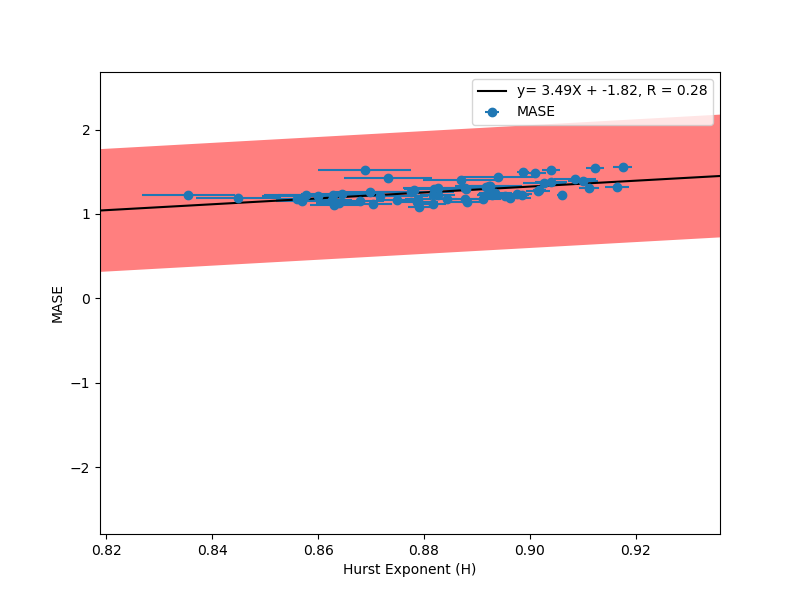

In [296]:
sixty_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for ANN at 1 minute horizon')
plt.ylim([0, 2.5])

In [293]:
sixty_min_tester.errors.to_csv('results/sixty_minute_ann_results.csv')

## Experimentation

In [5]:
# create model
model = Sequential()
model.add(Dense(400, input_dim=100, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [6]:
# create model
model = Sequential()
model.add(Dense(200, input_dim=1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [123]:
# create model
model = Sequential()
model.add(Dense(200, input_dim=100, activation='relu'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(5, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

EarlyStopping(monitor='mae', min_delta=0, patience=1)

In [131]:
horizon = 5
column = 'window_1_0'
col = data[column]

split = int(0.20 * len(data))
train, test = data[column][:split].values, data[column][split:].values

tester.predictions[column] = np.zeros((int((len(data) - len(data) * 0.2)), horizon))

# Round to be a multiple of the horizon
test = test[:len(test) - len(test) % horizon]

col = data[column].values.flatten()
indexer = np.arange(back_horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
X = col[indexer]

indexer = back_horizon + np.arange(horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
y = col[indexer]
# y = y / y_max

sc = MinMaxScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

preds = []
actuals = []
for (X_train, X_test, y_train, y_test) in xy_backtest(X, y, 0.2, int(0.8 * len(X)) // 10): 
    model.fit(X_train, y_train, validation_split=0.2, epochs=20)
    preds += [model.predict(X_test)]
    actuals += [y_test]
#     break

Train on 2753 samples, validate on 689 samples
Epoch 1/20
2753/2753 [==============================] - 0s 153us/step - loss: 0.0017 - mean_absolute_error: 0.0212 - val_loss: 0.0041 - val_mean_absolute_error: 0.0285
Epoch 2/20
2753/2753 [==============================] - 0s 114us/step - loss: 0.0019 - mean_absolute_error: 0.0250 - val_loss: 0.0039 - val_mean_absolute_error: 0.0292
Epoch 3/20
2753/2753 [==============================] - 0s 101us/step - loss: 0.0017 - mean_absolute_error: 0.0213 - val_loss: 0.0042 - val_mean_absolute_error: 0.0313
Epoch 4/20
2753/2753 [==============================] - 0s 106us/step - loss: 0.0016 - mean_absolute_error: 0.0217 - val_loss: 0.0046 - val_mean_absolute_error: 0.0421
Epoch 5/20
2753/2753 [==============================] - 0s 115us/step - loss: 0.0016 - mean_absolute_error: 0.0214 - val_loss: 0.0045 - val_mean_absolute_error: 0.0367
Epoch 6/20
2753/2753 [==============================] - 0s 97us/step - loss: 0.0016 - mean_absolute_error: 0.0211

Epoch 9/20
4955/4955 [==============================] - 1s 103us/step - loss: 0.0019 - mean_absolute_error: 0.0233 - val_loss: 0.0034 - val_mean_absolute_error: 0.0265
Epoch 10/20
4955/4955 [==============================] - 0s 99us/step - loss: 0.0019 - mean_absolute_error: 0.0221 - val_loss: 0.0033 - val_mean_absolute_error: 0.0277
Epoch 11/20
4955/4955 [==============================] - 1s 113us/step - loss: 0.0019 - mean_absolute_error: 0.0219 - val_loss: 0.0034 - val_mean_absolute_error: 0.0255
Epoch 12/20
4955/4955 [==============================] - 0s 91us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - val_loss: 0.0034 - val_mean_absolute_error: 0.0263
Epoch 13/20
4955/4955 [==============================] - 1s 104us/step - loss: 0.0019 - mean_absolute_error: 0.0234 - val_loss: 0.0038 - val_mean_absolute_error: 0.0357
Epoch 14/20
4955/4955 [==============================] - 1s 102us/step - loss: 0.0019 - mean_absolute_error: 0.0229 - val_loss: 0.0033 - val_mean_absolute_err

Epoch 5/20
10459/10459 [==============================] - 1s 103us/step - loss: 0.0023 - mean_absolute_error: 0.0225 - val_loss: 0.0031 - val_mean_absolute_error: 0.0244
Epoch 6/20
10459/10459 [==============================] - 1s 97us/step - loss: 0.0023 - mean_absolute_error: 0.0232 - val_loss: 0.0033 - val_mean_absolute_error: 0.0263
Epoch 7/20
10459/10459 [==============================] - 1s 97us/step - loss: 0.0023 - mean_absolute_error: 0.0228 - val_loss: 0.0035 - val_mean_absolute_error: 0.0324
Epoch 8/20
10459/10459 [==============================] - 1s 96us/step - loss: 0.0023 - mean_absolute_error: 0.0226 - val_loss: 0.0033 - val_mean_absolute_error: 0.0261
Epoch 9/20
10459/10459 [==============================] - 1s 102us/step - loss: 0.0022 - mean_absolute_error: 0.0230 - val_loss: 0.0033 - val_mean_absolute_error: 0.0269
Epoch 10/20
10459/10459 [==============================] - 1s 93us/step - loss: 0.0023 - mean_absolute_error: 0.0234 - val_loss: 0.0039 - val_mean_absolu

Epoch 12/20
12660/12660 [==============================] - 1s 111us/step - loss: 0.0022 - mean_absolute_error: 0.0229 - val_loss: 0.0042 - val_mean_absolute_error: 0.0326
Epoch 13/20
12660/12660 [==============================] - 1s 104us/step - loss: 0.0022 - mean_absolute_error: 0.0216 - val_loss: 0.0040 - val_mean_absolute_error: 0.0284
Epoch 14/20
12660/12660 [==============================] - 1s 98us/step - loss: 0.0022 - mean_absolute_error: 0.0214 - val_loss: 0.0042 - val_mean_absolute_error: 0.0322
Epoch 15/20
12660/12660 [==============================] - 1s 97us/step - loss: 0.0022 - mean_absolute_error: 0.0221 - val_loss: 0.0040 - val_mean_absolute_error: 0.0305
Epoch 16/20
12660/12660 [==============================] - 1s 104us/step - loss: 0.0022 - mean_absolute_error: 0.0215 - val_loss: 0.0039 - val_mean_absolute_error: 0.0288
Epoch 17/20
12660/12660 [==============================] - 1s 100us/step - loss: 0.0021 - mean_absolute_error: 0.0216 - val_loss: 0.0043 - val_mean

In [132]:
model.predict(X_test)[:5]

array([[0.58553505, 0.58622265, 0.5825584 , 0.5813097 , 0.60677963],
       [0.5849761 , 0.58567786, 0.58203244, 0.58078915, 0.60623735],
       [0.58441746, 0.58513165, 0.58150357, 0.5802655 , 0.6056936 ],
       [0.5838531 , 0.5845795 , 0.5809694 , 0.5797352 , 0.60514206],
       [0.5832914 , 0.58403116, 0.58044016, 0.5792105 , 0.6045953 ]],
      dtype=float32)

In [133]:
y_test[:5]

array([[0.57496187, 0.57822415, 0.57653138, 0.58003689, 0.60646316],
       [0.57436879, 0.57762582, 0.5759365 , 0.5794426 , 0.60584046],
       [0.5737791 , 0.57703091, 0.57534503, 0.57884491, 0.60521419],
       [0.57318602, 0.57643258, 0.57475015, 0.57824721, 0.60458791],
       [0.57259294, 0.57583425, 0.57415528, 0.57764951, 0.60396521]])

In [134]:
preds = np.vstack(preds)
actuals = np.vstack(actuals)
preds.shape, actuals.shape

((13760, 5), (13760, 5))

In [137]:
np.zeros((int((len(data) - len(data) * 0.2)), horizon)).shape

(69006, 5)

In [135]:
np.sqrt(mean_squared_error(sc.inverse_transform(preds), sc.inverse_transform(actuals)))

165.83484700192892

<IPython.core.display.Javascript object>


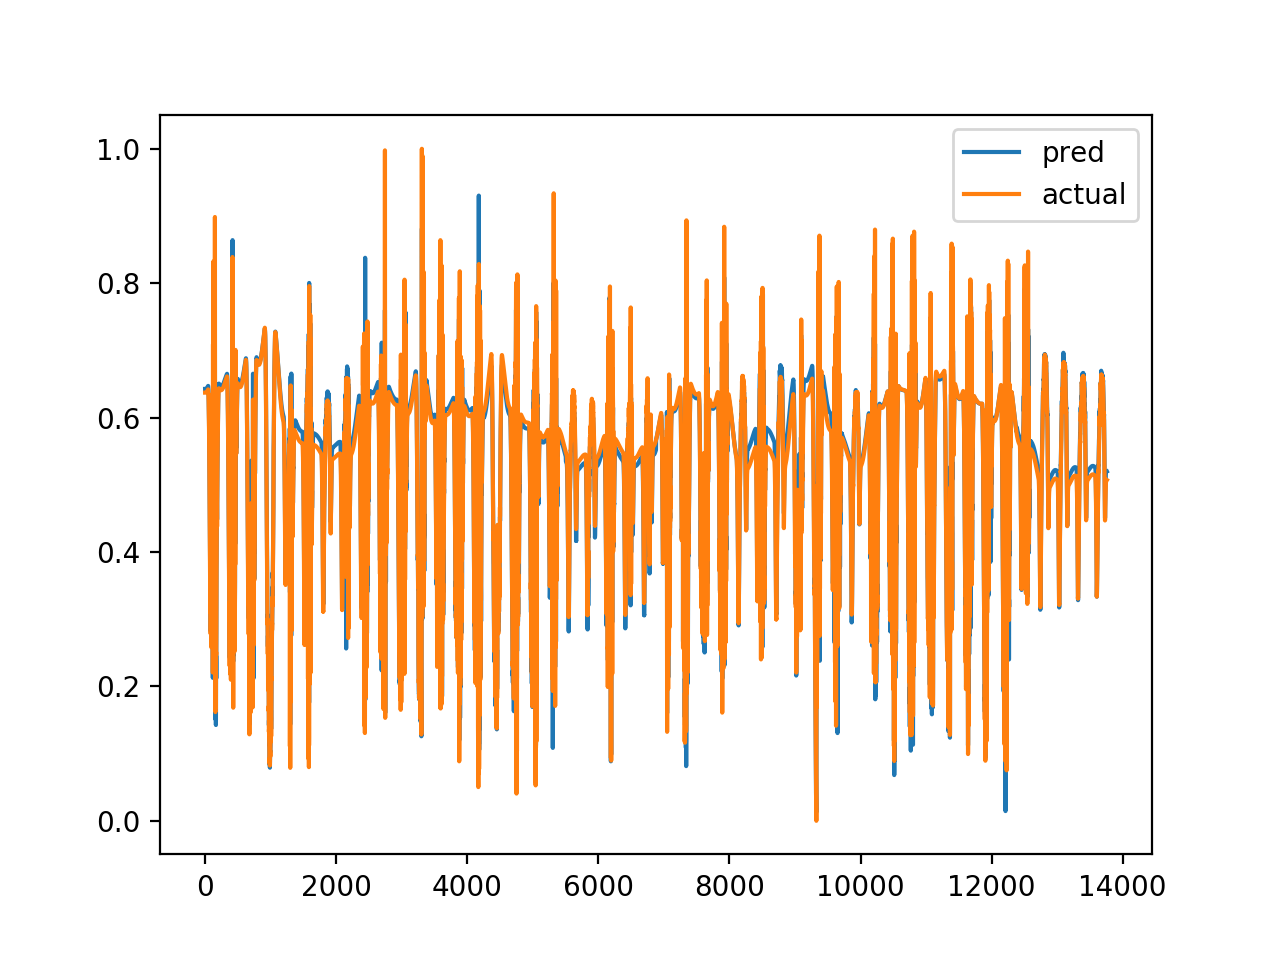

In [136]:
%matplotlib notebook
plt.plot(preds[:, 0])
plt.plot(actuals[:, 0])
plt.legend(['pred', 'actual'])